Core Libraries:

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, AveragePooling2D, MaxPooling2D,
    ZeroPadding2D, Activation, Dense, Flatten, Input, Add, ReLU
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.applications import resnet
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import cv2
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
from keras.layers import Input, Conv2D, BatchNormalization, Activation, AveragePooling2D, Flatten, Dense, Add
from keras.models import Model
from keras.regularizers import l2
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
from tensorflow.keras import layers, Model, applications
sns.set(style='white', context='notebook', palette='deep')

WikiArt Dataset:

In [2]:
# Load and map genres, styles classes
datapath = '/kaggle/input/wikiart'
genres_datapath = '/kaggle/input/genres-ds'
styles_datapath = '/kaggle/input/style-ds'

def process_classes(data_path,file_name):
    file_path =  data_path+'/'+file_name+'.txt'
    classes = {}
    with open(file_path, 'r') as f:
        for line in f:
            index, label = line.strip().split(' ', 1)
            classes[int(index)] = label
    return classes

genres_classes = process_classes(genres_datapath,'genre_class')
styles_classes = process_classes(styles_datapath,'style_class')
print(f"Genres:\n{genres_classes}\n")
print(f"Styles:\n{styles_classes}")

Genres:
{0: 'abstract_painting', 1: 'cityscape', 2: 'genre_painting', 3: 'illustration', 4: 'landscape', 5: 'nude_painting', 6: 'portrait', 7: 'religious_painting', 8: 'sketch_and_study', 9: 'still_life'}

Styles:
{0: 'Abstract_Expressionism', 1: 'Action_painting', 2: 'Analytical_Cubism', 3: 'Art_Nouveau', 4: 'Baroque', 5: 'Color_Field_Painting', 6: 'Contemporary_Realism', 7: 'Cubism', 8: 'Early_Renaissance', 9: 'Expressionism', 10: 'Fauvism', 11: 'High_Renaissance', 12: 'Impressionism', 13: 'Mannerism_Late_Renaissance', 14: 'Minimalism', 15: 'Naive_Art_Primitivism', 16: 'New_Realism', 17: 'Northern_Renaissance', 18: 'Pointillism', 19: 'Pop_Art', 20: 'Post_Impressionism', 21: 'Realism', 22: 'Rococo', 23: 'Romanticism', 24: 'Symbolism', 25: 'Synthetic_Cubism', 26: 'Ukiyo_e'}


In [3]:
# Load train and validation data
genre_data_valid = pd.read_csv(genres_datapath+'/genre_val.csv')
genre_data_train = pd.read_csv(genres_datapath+'/genre_train.csv')
genre_data_train.head()

,filename,genre
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3
2,Expressionism/martiros-saryan_mother-of-the-ar...,6
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6


In [4]:
style_data_valid = pd.read_csv(
    styles_datapath + '/style_val.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train = pd.read_csv(
    styles_datapath + '/style_train.csv',
    header=None,
    names=['filename', 'style']
)
style_data_train.head()

,filename,style
0,Impressionism/edgar-degas_landscape-on-the-orn...,12
1,Realism/camille-corot_mantes-cathedral.jpg,21
2,Abstract_Expressionism/gene-davis_untitled-197...,0
3,Symbolism/kuzma-petrov-vodkin_in-the-1920.jpg,24
4,Impressionism/maurice-prendergast_paris-boulev...,12


In [5]:
# Merge datasets on filename (assuming filenames are unique and match)
data_train = pd.merge(genre_data_train, style_data_train, on='filename', suffixes=('_genre', '_style'))
data_valid = pd.merge(genre_data_valid , style_data_valid , on='filename', suffixes=('_genre', '_style'))
data_train.head()

,filename,genre,style
0,Post_Impressionism/vincent-van-gogh_ears-of-wh...,4,20
1,Symbolism/theodor-severin-kittelsen_kvitebj-rn...,3,24
2,Expressionism/martiros-saryan_mother-of-the-ar...,6,9
3,Early_Renaissance/leonardo-da-vinci_study-for-...,8,8
4,Expressionism/jose-gutierrez-solana_old-mounta...,6,9


In [6]:
# Check for missing values
print(f"train:\n{data_train.isnull().sum()}\n")
print(f"validation:\n{data_valid.isnull().sum()}")

train:
filename    0
genre       0
style       0
dtype: int64

validation:
filename    0
genre       0
style       0
dtype: int64


In [7]:
# Identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for filename in dataframe['filename']:
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files

invalid_filenames_train = find_invalid_filenames(data_train, datapath)
invalid_filenames_valid = find_invalid_filenames(data_valid, datapath)

print(f"Number of invalid files in train data: {len(invalid_filenames_train)}")
print(f"Number of invalid files in valid data: {len(invalid_filenames_valid)}")

Number of invalid files in train data: 421
Number of invalid files in valid data: 191


In [8]:
# Remove invalid filenames from both train and validation datasets
data_train_cleaned = data_train[~data_train['filename'].isin(invalid_filenames_train)]
print(f"Number of valid rows in train after cleaning: {len(data_train_cleaned)}")

data_valid_cleaned = data_valid[~data_valid['filename'].isin(invalid_filenames_valid)]
print(f"Number of valid rows in valid after cleaning: {len(data_valid_cleaned)}")


Number of valid rows in train after cleaning: 44868
Number of valid rows in valid after cleaning: 19149


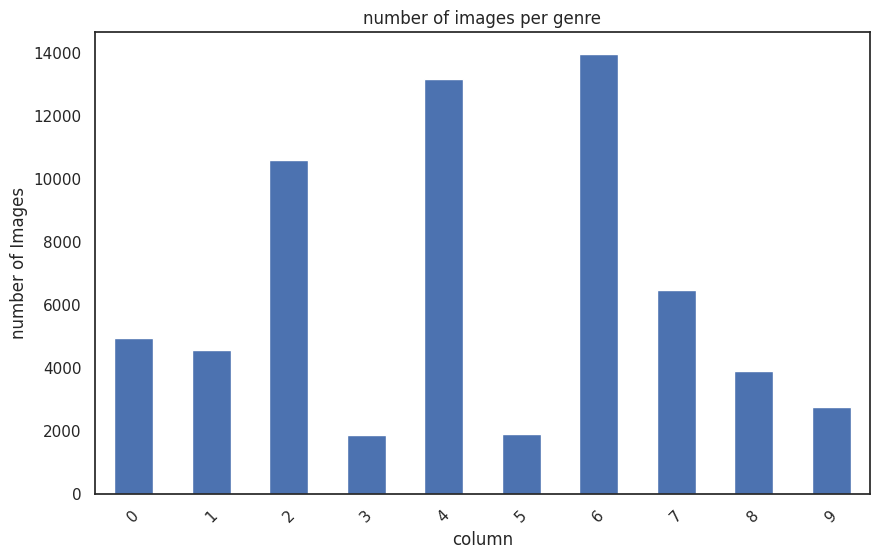

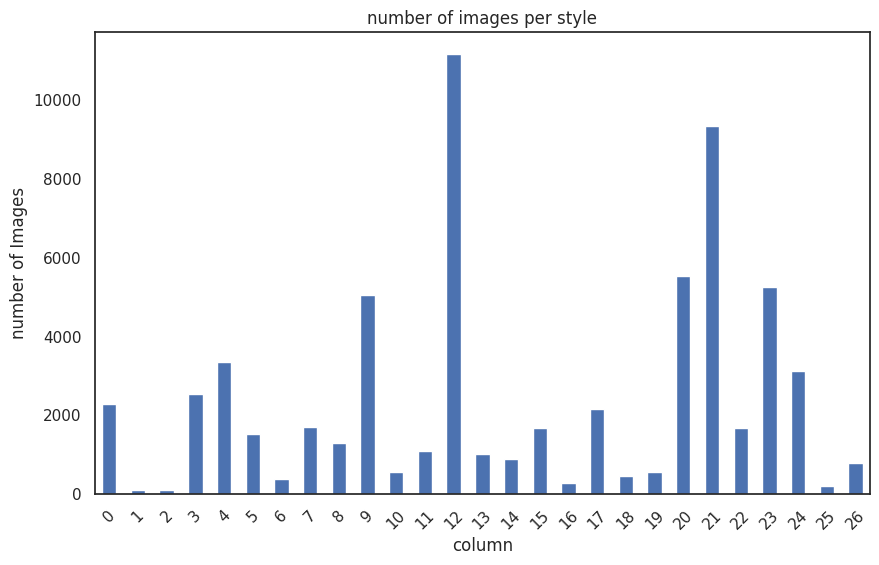

In [9]:
# Visualize the genres , styles distribution
def visualize_data(data_train,data_val,column,classes):
    combined_data = (data_train_cleaned[column].value_counts() + data_valid_cleaned[column].value_counts())
    combined_data.sort_index().plot(kind='bar', figsize=(10, 6), legend=False)
    plt.title(f"number of images per {column}")
    plt.ylabel("number of Images")
    plt.xlabel('column')
    plt.xticks(rotation=45)
    plt.show()
visualize_data(data_train_cleaned,data_valid_cleaned,'genre',genres_classes)
visualize_data(data_train_cleaned,data_valid_cleaned,'style',styles_classes)

In [10]:
# Split the training data into training and testing sets (80% train, 20% test)
data_train, data_test = train_test_split(data_train_cleaned, test_size=0.2, random_state=42, stratify=data_train_cleaned['genre'])
print(data_train.shape)
print(data_valid_cleaned.shape)
print(data_test.shape)

(35894, 3)
(19149, 3)
(8974, 3)


In [11]:
# Balance classes for training
def balance_classes(column,data):
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(data[column]),
        y=data[column]
    )
    class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
    return class_weights_dict

genres_class_weights = balance_classes('genre',data_train)
styles_class_weights = balance_classes('style',data_train)
print(f"Balanced Genres:\n{genres_class_weights}\n")
print(f"Balanced Styles:\n{styles_class_weights}")

Balanced Genres:
{0: 1.2990951863916034, 1: 1.4103732809430256, 2: 0.606112799729821, 3: 3.40550284629981, 4: 0.4870284938941655, 5: 3.3514472455648927, 6: 0.4597079918032787, 7: 0.9899062327633756, 8: 1.6472693896282697, 9: 2.3068123393316196}

Balanced Styles:
{0: 1.0337538160244226, 1: 24.17104377104377, 2: 21.44205495818399, 3: 0.9408403449450866, 4: 0.7015342519300303, 5: 1.5530460366908965, 6: 6.5167029774872915, 7: 1.4127602629196678, 8: 1.8336653895274584, 9: 0.4697552676351263, 10: 4.431358024691358, 11: 2.1476694788488, 12: 0.21189152174169706, 13: 2.352933464437889, 14: 2.674863998807661, 15: 1.3876904043918659, 16: 8.80402256561197, 17: 1.1014145877443309, 18: 5.093514970909607, 19: 4.431358024691358, 20: 0.4289794796409834, 21: 0.25448074414383753, 22: 1.426402797647433, 23: 0.4526412691206699, 24: 0.7679996576588142, 25: 10.635259259259259, 26: 2.9740657883834616}


In [21]:
def create_generator(df, datapath, generator,shuffle_flag):
    return generator.flow_from_dataframe(
        dataframe=df,
        directory=datapath,
        x_col='filename',
        y_col=['genre', 'style'],
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        shuffle=shuffle_flag
    )
def multi_output_generator(generator):
    for x, y in generator:
        yield x, {"genre": y[:, 0], "style": y[:, 1]}
# Apply augmentation on training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)
train_generator = create_generator(data_train,datapath,train_datagen,True)
train_generator = multi_output_generator(train_generator)
# Validation generator
valid_datagen = ImageDataGenerator(
    rescale=1./255
)
valid_generator = create_generator(data_valid_cleaned,datapath,valid_datagen,False) 
valid_generator = multi_output_generator(valid_generator)
# Testing generator
test_datagen = ImageDataGenerator(
   rescale=1./255
)
test_generator = create_generator(data_test,datapath,test_datagen,False) 
test_generator = multi_output_generator(test_generator)

Found 35894 validated image filenames.
Found 19149 validated image filenames.
Found 8974 validated image filenames.


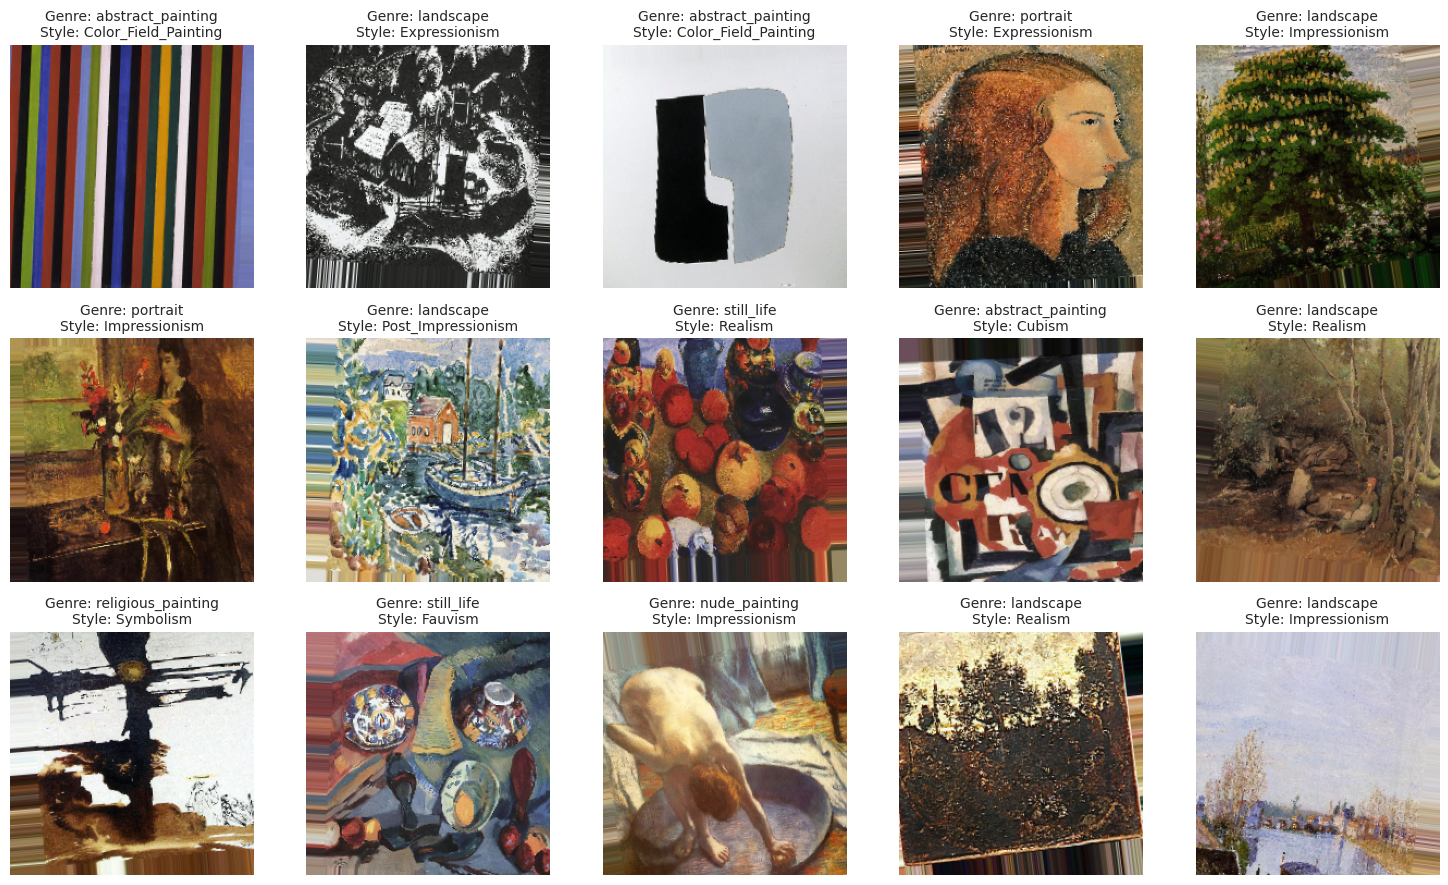

In [22]:
image_batch, labels_dict = next(train_generator)
genre_labels = labels_dict["genre"]
style_labels = labels_dict["style"]
plt.figure(figsize=(15, 9))
for i in range(15):
    plt.subplot(3, 5, i + 1)
    plt.imshow(image_batch[i])
    genre_label = genres_classes[int(genre_labels[i])]
    style_label = styles_classes[int(style_labels[i])]
    plt.title(f"Genre: {genre_label}\nStyle: {style_label}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [31]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

num_genres = 10
num_styles = 27
learning_rate = 1e-3 

# input layer
inputs = Input(shape=(224, 224, 3))
# Load DenseNet121 as a feature extractor
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = False  # Freeze the base model

# Extract features
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)

# Genre classification branch
genre_branch = Dense(128, activation='relu')(x)
genre_branch = Dropout(0.2)(genre_branch)
genre_output = Dense(num_genres, activation='softmax', name="genre")(genre_branch)

# Style classification branch
style_branch = Dense(256, activation='relu')(x)
style_branch = Dropout(0.3)(style_branch)
style_output = Dense(num_styles, activation='softmax', name="style")(style_branch)

# Define model with multiple outputs
model = Model(inputs=inputs, outputs=[genre_output, style_output])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss={"genre": "sparse_categorical_crossentropy", "style": "sparse_categorical_crossentropy"},
    metrics={"genre": ["accuracy"], "style": ["accuracy"]}
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ densenet121 (Functional)  │ (None, 7, 7, 1024)     │      7,037,504 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1024)           │              0 │ densenet121[0][0]      │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 128)            │        131,200 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 256)            │        262,400 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_17 (Dropout)      │ (None, 128)            │              0 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_18 (Dropout)      │ (None, 256)            │              0 │ dense_18[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genre (Dense)             │ (None, 10)             │          1,290 │ dropout_17[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ style (Dense)             │ (None, 27)             │          6,939 │ dropout_18[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,439,333 (28.38 MB)

 Trainable params: 401,829 (1.53 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [32]:
# Train model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch = int(np.ceil(len(data_train) / 32)),
    validation_steps = int(np.ceil(len(data_valid) / 32)),
)

Epoch 1/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1816s 2s/step - genre_accuracy: 0.5681 - loss: 3.5337 - style_accuracy: 0.3074 - val_genre_accuracy: 0.6712 - val_loss: 2.6534 - val_style_accuracy: 0.4388
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1521s 1s/step - genre_accuracy: 0.6667 - loss: 2.7678 - style_accuracy: 0.4146 - val_genre_accuracy: 0.6727 - val_loss: 2.5576 - val_style_accuracy: 0.4589
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1364s 1s/step - genre_accuracy: 0.6818 - loss: 2.6190 - style_accuracy: 0.4466 - val_genre_accuracy: 0.6945 - val_loss: 2.4756 - val_style_accuracy: 0.4671
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1350s 1s/step - genre_accuracy: 0.6905 - loss: 2.5400 - style_accuracy: 0.4537 - val_genre_accuracy: 0.6914 - val_loss: 2.5154 - val_style_accuracy: 0.4620
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1314s 1s/step - genre_accuracy: 0.6962 - loss: 2.5011 - style_accuracy: 0.4658 - val_genre_accuracy: 0.7002 - val_loss: 2.4301 - val_style_accuracy: 0.4796
Epoch 6/10

In [40]:
# Fine-tuning: Unfreeze some layers of DenseNet
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 100  # Unfreeze last 100 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss={"genre": "sparse_categorical_crossentropy", "style": "sparse_categorical_crossentropy"},
    metrics={"genre": ["accuracy"], "style": ["accuracy"]}
)

# Train model
finetuning_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    initial_epoch = 0,
    steps_per_epoch = int(np.ceil(len(data_train) / 32)),
    validation_steps = int(np.ceil(len(data_valid) / 32)),
    verbose=1
)

Epoch 1/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1798s 2s/step - genre_accuracy: 0.6559 - loss: 3.0296 - style_accuracy: 0.3928 - val_genre_accuracy: 0.7017 - val_loss: 2.4993 - val_style_accuracy: 0.4782
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1727s 2s/step - genre_accuracy: 0.7046 - loss: 2.4312 - style_accuracy: 0.4807 - val_genre_accuracy: 0.7083 - val_loss: 2.4071 - val_style_accuracy: 0.4948
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1707s 2s/step - genre_accuracy: 0.7177 - loss: 2.2892 - style_accuracy: 0.5083 - val_genre_accuracy: 0.7122 - val_loss: 2.3658 - val_style_accuracy: 0.5014
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1763s 2s/step - genre_accuracy: 0.7176 - loss: 2.2610 - style_accuracy: 0.5167 - val_genre_accuracy: 0.7145 - val_loss: 2.3441 - val_style_accuracy: 0.5061
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 1644s 1s/step - genre_accuracy: 0.7300 - loss: 2.2102 - style_accuracy: 0.5176 - val_genre_accuracy: 0.7157 - val_loss: 2.3231 - val_style_accuracy: 0.5093
Epoch 6/10

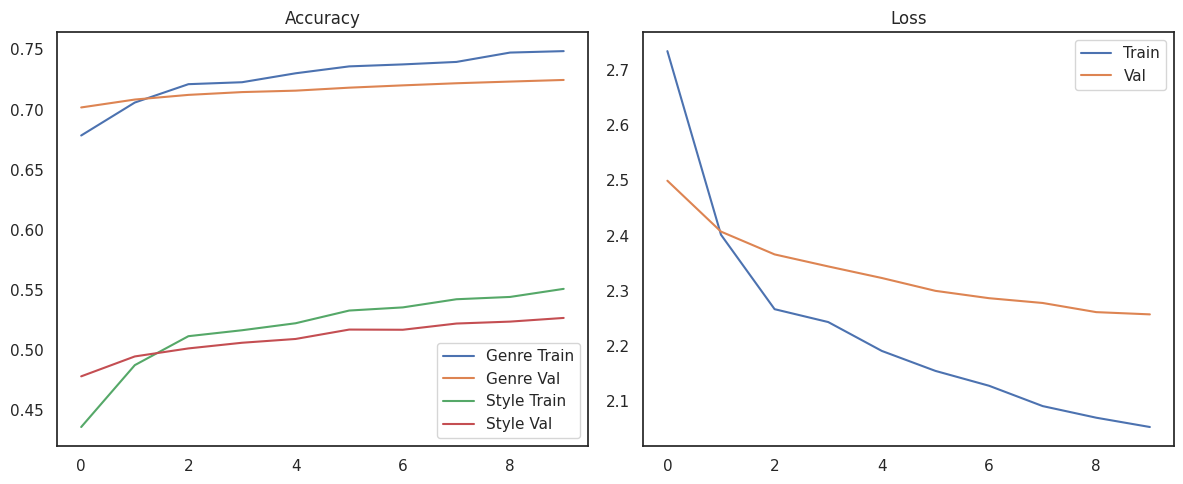

In [41]:
# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['genre_accuracy'], label='Genre Train')
    plt.plot(history.history['val_genre_accuracy'], label='Genre Val')
    plt.plot(history.history['style_accuracy'], label='Style Train')
    plt.plot(history.history['val_style_accuracy'], label='Style Val')
    plt.title('Accuracy')
    plt.legend()
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_history(finetuning_history)

In [42]:
# Save model
model.save('/kaggle/working/genres_styles_classification_model.h5')

import json
with open('/kaggle/working/style_classes.json', 'w') as f:
    json.dump(styles_classes, f)
with open('/kaggle/working/genre_classes.json', 'w') as f:
    json.dump(genres_classes, f)